In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
!pip install konlpy

In [49]:
!cp '/content/drive/MyDrive/code/실습/preprocess.py' .

In [50]:
import tensorflow as tf
import numpy as np
import os

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

from preprocess import *

In [51]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+ string])
    plt.show()

In [52]:
DATA_IN_PATH = '/content/drive/MyDrive/code/실습/data_in/'
DATA_OUT_PATH = '/content/drive/MyDrive/code/실습/models/'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIG = 'data_configs.json'

In [53]:
SEED_NUM = 42
tf.random.set_seed(SEED_NUM)

In [54]:
index_inputs = np.load(open(DATA_IN_PATH + TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH + TRAIN_OUTPUTS, 'rb'))
index_targets = np.load(open(DATA_IN_PATH + TRAIN_TARGETS, 'rb'))
prepro_config = json.load(open(DATA_IN_PATH + DATA_CONFIG, 'r'))

In [55]:
MODEL_NAME = 'transformer_kor'
BATCH_SIZE = 24
MAX_SEQUENCE = 25
EPOCH = 30

VALIDATION_SPLIT = 0.1

word2idx = prepro_config['word2idx']
idx2word = prepro_config['idx2word']
sos_idx = prepro_config['sos_symbol']
eos_idx = prepro_config['eos_symbol']
vocab_size = prepro_config['vocab_size']


kargs = {'model_name': MODEL_NAME, 
         'num_layer': 2, 
         'd_model': 512, 
         'num_heads':8,
         'dff':2048, 
         'input_vocab_size':vocab_size,
         'output_vocab_size':vocab_size,
         'maximum_position_encoding':MAX_SEQUENCE,
         'end_token_idx': word2idx[eos_idx],
         'rate':0.1
         }

In [56]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    return seq[:, tf.newaxis, tf.newaxis, :]

In [57]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size,size)), -1, 0)
    return mask

In [58]:
input = tf.constant([[ 0,  1,  2, 3],
 [-1,  0,  1, 2],
[-2, -1,  0, 1],
 [-3, -2, -1, 0]])

tf.linalg.band_part(
    input, num_lower, num_upper, name=None
) <br>

band[i, j, k, ..., m, n] = in_band(m, n) * input[i, j, k, ..., m, n].<br>
in_band(m, n) = (num_lower < 0 || (m-n) <= num_lower)) && (num_upper < 0 || (n-m) <= num_upper).<br>

In [59]:
input = tf.constant([[ 4,  1,  2, 3],
 [-1,  2,  1, 2],
[-2, -1,  5, 1],
 [-3, -2, -1, 1]])
input

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[ 4,  1,  2,  3],
       [-1,  2,  1,  2],
       [-2, -1,  5,  1],
       [-3, -2, -1,  1]], dtype=int32)>

In [60]:
tf.linalg.band_part(input, -1, 0)

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[ 4,  0,  0,  0],
       [-1,  2,  0,  0],
       [-2, -1,  5,  0],
       [-3, -2, -1,  1]], dtype=int32)>

In [61]:
def create_masks(input, target):
    enc_padding_mask = create_padding_mask(input)
    dec_padding_mask = create_padding_mask(input)

    look_ahead_mask = create_look_ahead_mask(tf.shape(target)[1])
    dec_target_padding_mask = create_padding_mask(target)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [62]:
enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(index_inputs, index_outputs)

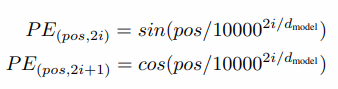

In [63]:
def get_angles(pos, i, d_model):
    angle_rate = 1/np.power(10000, (2 * i // 2) / np.float(d_model))
    return pos * angle_rate

In [64]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis], 
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


<function matplotlib.pyplot.show>

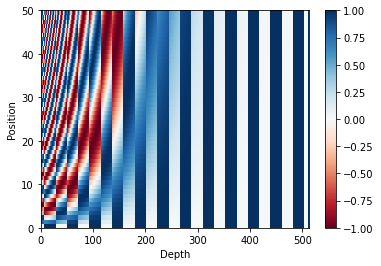

In [65]:
pos_encoding = positional_encoding(50,512)
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim(0,512)
plt.ylabel('Position')
plt.colorbar()
plt.show

In [66]:
angle_rate = 1/np.power(10000, (2 * 0) / np.float(512))
angle_rate

1.0

In [69]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)

    return output, attention_weights

In [70]:

mask = []
if mask:
    print('mask is not []')

if mask is not None:
    print("mask is not None")

mask is not None


In [71]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = kargs['num_heads']
        self.d_model = kargs['d_model']

        assert self.d_model % self.num_heads == 0

        self.depth = self.d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(kargs['d_model'])
        self.wk = tf.keras.layers.Dense(kargs['d_model'])
        self.wv = tf.keras.layers.Dense(kargs['d_model'])

        self.dense = tf.keras.layers.Dense(kargs['d_model'])

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weight = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention)

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        output = self.dense(concat_attention)

        return output, attention_weight
